In [1]:
import jax
from jax import config
config.update("jax_enable_x64", True)  
import jax.numpy as jnp
from jax import jit, vmap, grad
import zodiax as zdx

import numpy as np
from harmonix.harmonix import Harmonix, visibilities, closure_phases
from harmonix.utils import maketriples_all, makebaselines
from jaxoplanet.starry import Surface, Ylm, show_surface
from jaxoplanet.starry.light_curves import surface_light_curve


import matplotlib.pyplot as plt
import paths
from functools import partial

from skyfield.api import load
from skyfield.api import Star
from skyfield.api import Loader

from skyfield.data import hipparcos
from skyfield.api import N,S,E,W, wgs84
plt.rcParams.update({'font.size': 12})

# CHARA SPOT problem optimization:

In this notebook, I try to optimize for the surface map of the star in the $\texttt{SPOT}$ problem to see how well we can recover it. 

## Telescope simulation:

First get the simulated u, v coordinates

cp_inds shape: (20, 3)
cp_uvs shape: (20, 2, 2)
Loading earth data...
Loading Hipparcos data on Alioth...


Text(0, 0.5, 'V (lambdas)')

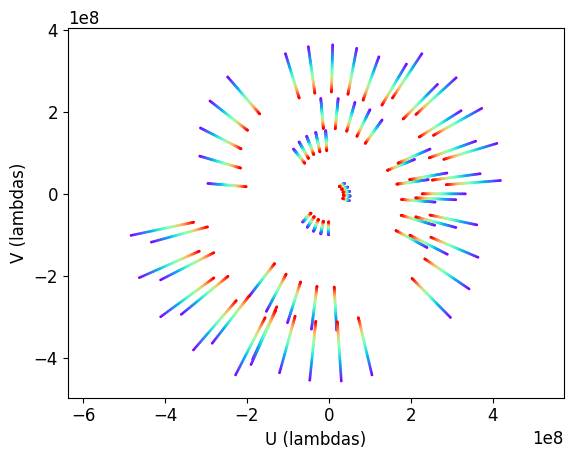

In [2]:
load = Loader(paths.data)

HOUR_ANGLES = 5
#using SPICA lowres
WAVS = 50

chara_tels = np.array(
    [[0, 0],
    [330.66,22.28],
    [-313.53,253.39],
    [302.33,25.7],
    [-221.82,241.27],
    [-65.88,236.6]])
#for some reason the file is rotated by 90 degrees
theta = 0
chara_tels[:,1] = chara_tels[:,1] + theta
station_x = chara_tels[:,0]*np.cos(np.radians(chara_tels[:,1]))
station_y = chara_tels[:,0]*np.sin(np.radians(chara_tels[:,1]))
station_x-=np.abs(station_x.min())
station_y+=np.abs(station_y.min())

cp_inds, cp_uvs = maketriples_all(np.vstack([station_x, station_y]).T)[0:10]
print("cp_inds shape: " + str(cp_inds.shape))
baseline_inds, baselines = makebaselines(np.vstack([station_x, station_y]).T)

print("cp_uvs shape: " + str(cp_uvs.shape))

print("Loading earth data...")
ts = load.timescale()
    
t =ts.utc(2023, 3, 23, np.linspace(8,12,HOUR_ANGLES))
planets = load('de421.bsp')
earth = planets['earth']

print("Loading Hipparcos data on Alioth...")
with load.open(hipparcos.URL) as f:
    df = hipparcos.load_dataframe(f)

latitude = 34.2249
chara = earth + wgs84.latlon(latitude * N, 118.0564 * W, elevation_m=1740)
alioth = Star.from_dataframe(df.loc[62956])
position = chara.at(t).observe(alioth).apparent()

ha, dec, distance = position.hadec()

#matrix to project a star's changing hour angle and declination onto the baselines
#to create uv tracks
proj_mat = []
for h, d in zip(ha.radians, dec.radians):
    proj_mat.append(np.array([[np.sin(h), np.cos(h), 0],
                  [-np.sin(d)*np.cos(h), np.sin(d)*np.sin(h), np.cos(d)],
                  [np.cos(d)*np.cos(h), -np.cos(d)*np.sin(h), np.sin(d)]]))
proj_mat = np.array(proj_mat)
proj_mat.shape

#project the baselines onto the uv plane
#project the baselines onto the uv plane
enu = np.insert(baselines, 2, 0, axis=1)
# Latitude in radians
latitude = np.deg2rad(latitude)  # example: 34 degrees

# Define the transformation matrix
T = np.array([
    [0, -np.sin(latitude), np.cos(latitude)],
    [1, 0, 0],
    [0, np.cos(latitude), np.sin(latitude)]
])

# Transform to (x, y, z)
xyz = enu @ T.T
wav = jnp.linspace(0.65*1e-6, 0.95*1e-6,WAVS)
uv = (proj_mat@xyz.T)[:,0:2]
#really complicated logic to first
#create a new axis for each wavelength
#then repeat the uv tracks for each wavelength
#then divide each uv track by the wavelength
#then transopse to get an array of (n_wavelengths, n_hourangles, 2, n_baselines)
uv_by_wav = (uv[np.newaxis,:,:].repeat(len(wav),axis=0).T/wav).T

u = np.concatenate(uv_by_wav[:,:,0],axis=0)
v = np.concatenate(uv_by_wav[:,:,1],axis=0)
wavs = wav.repeat(HOUR_ANGLES,axis=0).repeat(u.shape[1], axis=0)

fig1, ax = plt.subplots()
ax.set_aspect("equal", adjustable="datalim")
ax.scatter(u,v,c=wavs,cmap='rainbow',s=1.);
ax.set_xlabel("U (lambdas)")
ax.set_ylabel("V (lambdas)")

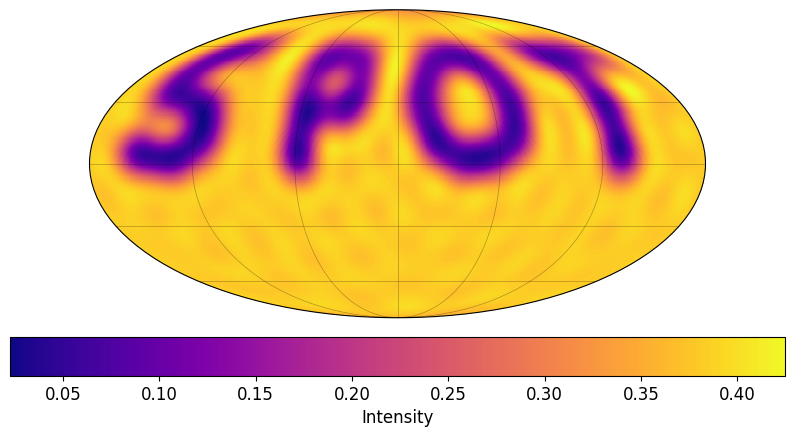

In [3]:
# Assume you have a Surface object with an intensity method
# For example:
y_star = np.load(paths.data / "SPOT_map_highres.npy")
y = Ylm.from_dense(y_star)
star = Surface(y=y, inc=jnp.radians(60.), obl=0, period=1.0)

radius = 1.47/2.
star_interferometry = Harmonix(star, radius)

# 1. Create longitude and latitude meshgrid
n_lon = 360*2
n_lat = 180*2

lon = jnp.linspace(-jnp.pi, jnp.pi, n_lon)
lat = jnp.linspace(-jnp.pi / 2, jnp.pi / 2, n_lat)
lon_grid, lat_grid = jnp.meshgrid(lon, lat)

# 2. Compute intensity at each (lat, lon)
intensity = star_interferometry.surface.intensity(lat_grid, lon_grid)[::-1, ::-1]

fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'}, figsize=(10, 5))
# ---------------------
# Plot the Mollweide map
pcm = ax.pcolormesh(np.asarray(lon_grid), np.asarray(lat_grid), np.asarray(intensity),
                       shading='auto', cmap='plasma', rasterized=True)
#ax[0].set_title("Surface Intensity Map (Mollweide Projection)")
ax.set_longitude_grid_ends(90)
ax.set_longitude_grid(60)
ax.set_latitude_grid(30)
ax.grid(True, linestyle='-', linewidth=0.5, color='k', alpha=0.3)
ax.tick_params(axis='x', labelbottom=False) # Hide x-axis tick labels
ax.tick_params(axis='y', labelleft=False)   # Hide y-axis tick labels
plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.05, label='Intensity')

## Simulate the true data:

Text(0, 0.5, 'Closure Phase (degrees)')

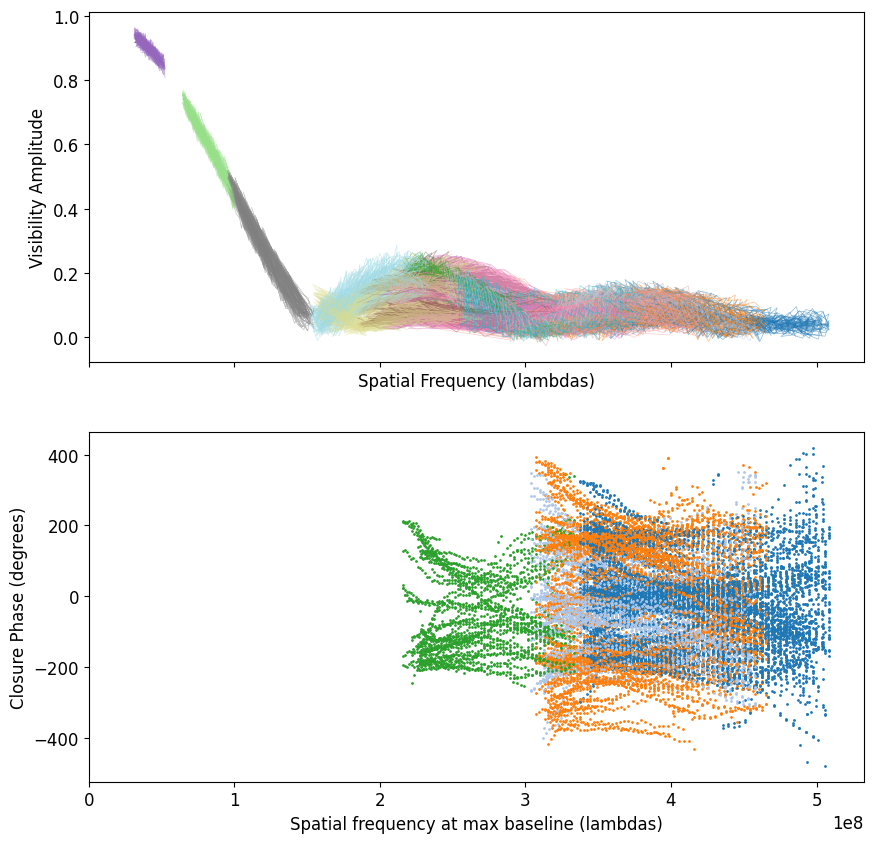

In [46]:
import jax.random as jr
times = jnp.linspace(0, 1, 8)  # Example times for the orthographic views


vis_true = visibilities(star_interferometry, jnp.array(u.T), jnp.array(v.T), times)
cp_true = closure_phases(star_interferometry, jnp.array(u.T), jnp.array(v.T),times, cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])

key = jr.PRNGKey(0)
vis_data = vis_true + jr.normal(key, vis_true.shape)/100.
cp_data = cp_true + jr.normal(key, cp_true.shape)*360./100.
fig1, ax_data = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

colors = plt.cm.tab20(np.linspace(0, 1, u.shape[1]))

for n in range(8):
    for i in range(u.shape[1]):
        ax_data[0].plot(jnp.sqrt(u[:,i]**2+v[:,i]**2), vis_data[n,i,:], alpha=0.5,color=colors[i], lw=0.5, rasterized=True)
    
    #get the maximum baseline for each closure phase
    cp_x_axis = []
    cp_x_color = []
    for i in range(10):
        #each station in the closure phase triple
        b1 = cp_inds[i,0]
        b2 = cp_inds[i,1]
        b3 = cp_inds[i,2]
        #each baseline in the closure phase triple, and its respectice index in u, v
        matches_1 = np.all(baseline_inds == [b1,b2], axis=1)
        ind1 = np.where(matches_1)[0]
        matches_2 = np.all(baseline_inds == [b2,b3], axis=1)
        ind2 = np.where(matches_2)[0]
        matches_3 = np.all(baseline_inds == [b1,b3], axis=1)
        ind3 = np.where(matches_3)[0]
        #and the index of the closure phase triple with the maximum baseline
        #the same index is repeated n_wavs times, so just take the first one
        max_baseline_ind = jnp.argmax(
            jnp.array([jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind1],
                       jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind2],
                       jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind3]]), axis=0)[0,0]
        if max_baseline_ind == 0:
            cp_x_axis.append(jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind1])
            cp_x_color.append(ind1)
        elif max_baseline_ind == 1:
            cp_x_axis.append(jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind2])
            cp_x_color.append(ind2)
        elif max_baseline_ind == 2:
            cp_x_axis.append(jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind3])
            cp_x_color.append(ind3)
        
    cp_x_color = np.array(cp_x_color)
    for i in range(len(cp_x_color)):
        ax_data[1].scatter(cp_x_axis[i], cp_data[n,i,:], color=colors[cp_x_color[i]], rasterized=True, s=1)

ax_data[0].set_xlabel('Spatial Frequency (lambdas)')
ax_data[0].set_xlim(left=0)
ax_data[0].set_ylabel('Visibility Amplitude')
ax_data[1].set_xlabel("Spatial frequency at max baseline (lambdas)")
ax_data[1].set_xlim(left=0)
ax_data[1].set_ylabel("Closure Phase (degrees)")

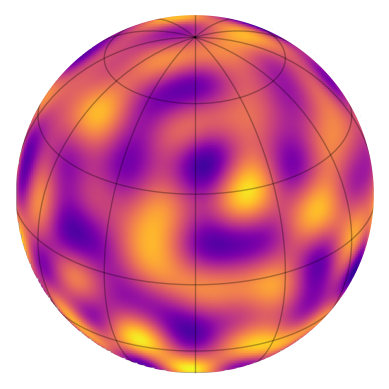

In [47]:
# Now lets construct a loss function
opt_params = ["data"]
l_max = 15
n_max = l_max**2 + 2 * l_max + 1
y_star = np.load(paths.data / "SPOT_map_highres.npy")
y_star[1:] /= 100.  # Normalize the coefficients
y_star[1:] += np.random.normal(scale=0.001, size=y_star[1:].shape)  # Set the zeroth coefficient to 1 for a constant term
y_star = jnp.array(y_star, dtype=jnp.float64)  # Ensure y_star is a JAX array
y = Ylm.from_dense(y_star)
star = Surface(y=y, inc=jnp.radians(60.), obl=0, period=1.0)
model = Harmonix(star, radius)
model_init = model
show_surface(star, cmap='plasma')

In [48]:
model_init.surface.y.todense()-star_interferometry.surface.y.todense()

Array([ 0.00000000e+00,  1.47174211e-01,  2.19371500e-02, -4.13491963e-03,
       -2.90935185e-03,  2.21746505e-02,  5.96102182e-03,  5.19280764e-02,
        4.65847105e-02,  7.71927563e-02,  1.54034960e-02,  5.07917641e-02,
        1.53490798e-03, -9.69435634e-03, -5.39287346e-03, -5.08666825e-03,
       -4.71956440e-03,  3.85339393e-03, -2.56309385e-02,  1.65501298e-02,
       -1.01108128e-01,  2.91743518e-02,  6.02639949e-02,  2.55727510e-02,
       -2.05771825e-02, -9.58795043e-03,  1.19902129e-02,  6.20668679e-02,
        1.08698533e-02, -5.42218496e-02,  8.10661440e-03,  3.12945672e-02,
       -2.98860030e-02,  1.82045951e-02, -2.78229723e-04,  9.39503003e-04,
       -4.10257534e-03, -9.14412970e-04, -9.51107650e-03, -1.96617654e-02,
        2.80981980e-02,  1.36795283e-02,  4.10094915e-02,  4.07316200e-02,
       -5.80765132e-03, -9.64114932e-04,  1.53195999e-02,  1.96749550e-02,
        3.45719616e-02,  3.66747905e-02,  2.67557611e-02,  6.57033717e-03,
       -3.23980030e-02, -

In [33]:
def angular_mse(predicted, target):
    delta = (predicted - target + jnp.pi) % (2 * jnp.pi) - jnp.pi
    return jnp.mean(delta**2)

@zdx.filter_jit
@zdx.filter_value_and_grad(opt_params)
def loss_fn(model, vis_data, cp_data, u, v, times, index_cps1, index_cps2, index_cps3):
    model_vis = visibilities(model, jnp.array(u.T), jnp.array(v.T), times)
    model_cp = closure_phases(model, jnp.array(u.T), jnp.array(v.T), times, index_cps1, index_cps2, index_cps3)
    #scale the noise in the closure phases by 360 degrees
    #gaussian prior penalty on the coefficients
    return (jnp.square((model_vis - vis_data)).mean() + angular_mse(jnp.radians(model_cp), jnp.radians(cp_data)))
    #return (jnp.square((model_cp - cp_data) / (360)).mean())

# Evaluate loss function once Compile to XLA
loss, grads = loss_fn(model, vis_data, cp_data, u, v, times, cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])

In [49]:
import optax

opt = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=1e-4)
)

# Get optax objcets
optimiser, state = zdx.get_optimiser(model, opt_params, opt)

losses = []
steps = []
gradients = []
datas = []
for i in range(6000):
    loss, grads = loss_fn(model, vis_data, cp_data, u, v, times, cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])
    gradients.append(grads.data)
    step, state = optimiser.update(grads, state, params=model)
    steps.append(step.data)
    datas.append(model.data)
    model = zdx.apply_updates(model, step)
    losses.append(loss)

Text(0, 0.5, 'Log10 Loss')

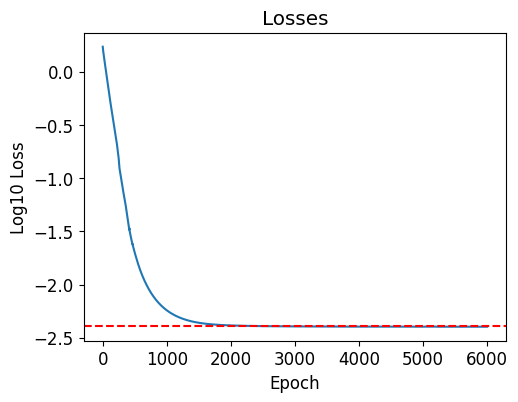

In [50]:
loss_true, grads_true = loss_fn(star_interferometry, vis_data, cp_data, u, v, times, cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.log10(np.array(losses)))
plt.axhline(np.log10(loss_true), color='red', linestyle='--', label='True Loss')
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Log10 Loss")

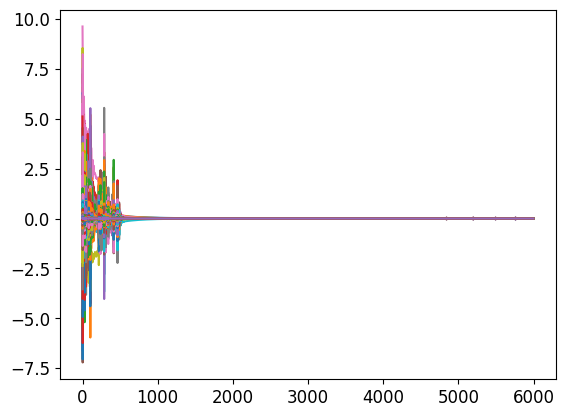

In [51]:
plt.plot([grad for grad in gradients], label='Coeff grads');

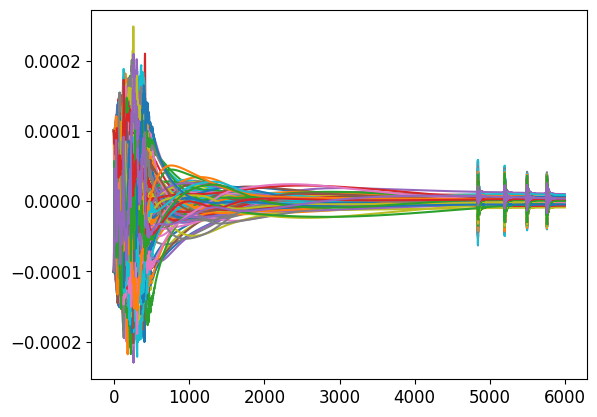

In [52]:
plt.plot([step for step in steps], label='Coeff steps');

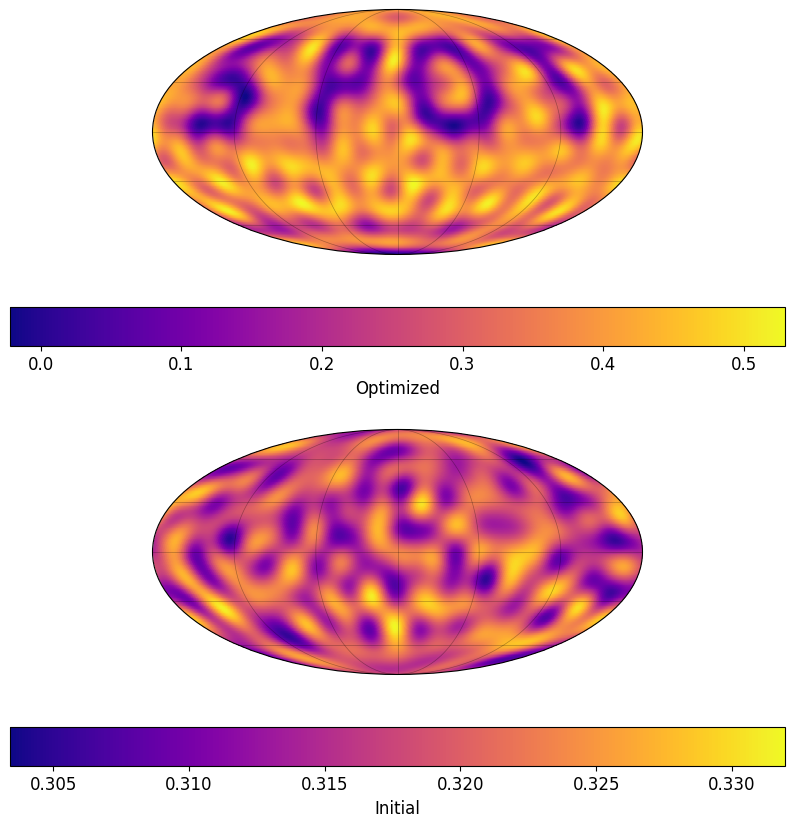

In [53]:
# 1. Create longitude and latitude meshgrid
n_lon = 360*2
n_lat = 180*2

lon = jnp.linspace(-jnp.pi, jnp.pi, n_lon)
lat = jnp.linspace(-jnp.pi / 2, jnp.pi / 2, n_lat)
lon_grid, lat_grid = jnp.meshgrid(lon, lat)

y_star = jnp.concatenate([jnp.array([1.0]), model.data])  # Ensure y_star is a JAX array
y = Ylm.from_dense(y_star)
star = Surface(y=y, inc=jnp.radians(60.), obl=0, period=1.0, normalize=True)
model_opt = Harmonix(star, radius)
# 2. Compute intensity at each (lat, lon)
intensity = model_opt.surface.intensity(lat_grid, lon_grid)[::-1, ::-1]

fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), subplot_kw={'projection': 'mollweide'})
# ---------------------
# Plot the Mollweide map
pcm = ax.pcolormesh(np.asarray(lon_grid), np.asarray(lat_grid), np.asarray(intensity),
                       shading='auto', cmap='plasma', rasterized=True)
#ax[0].set_title("Surface Intensity Map (Mollweide Projection)")
ax.set_longitude_grid_ends(90)
ax.set_longitude_grid(60)
ax.set_latitude_grid(30)
ax.grid(True, linestyle='-', linewidth=0.5, color='k', alpha=0.3)
ax.tick_params(axis='x', labelbottom=False) # Hide x-axis tick labels
ax.tick_params(axis='y', labelleft=False)   # Hide y-axis tick labels
plt.colorbar(pcm, ax=ax, orientation='horizontal', label='Optimized')

intensity = model_init.surface.intensity(lat_grid, lon_grid)[::-1, ::-1]
# Plot the Mollweide map
pcm = ax1.pcolormesh(np.asarray(lon_grid), np.asarray(lat_grid), np.asarray(intensity),
                       shading='auto', cmap='plasma', rasterized=True)
#ax[0].set_title("Surface Intensity Map (Mollweide Projection)")
ax1.set_longitude_grid_ends(90)
ax1.set_longitude_grid(60)
ax1.set_latitude_grid(30)
ax1.grid(True, linestyle='-', linewidth=0.5, color='k', alpha=0.3)
ax1.tick_params(axis='x', labelbottom=False) # Hide x-axis tick labels
ax1.tick_params(axis='y', labelleft=False)   # Hide y-axis tick labels
plt.colorbar(pcm, ax=ax1, orientation='horizontal', label='Initial')

In [39]:
star_interferometry.data-model.data

Array([-4.90570813e-02,  3.98151121e-03, -4.12239947e-04,  1.24735835e-03,
        6.51427651e-04, -2.42852064e-02,  3.93662691e-03, -4.66625182e-02,
        3.38127798e-02, -1.54631534e-03,  2.13919782e-02, -2.06227482e-03,
        5.29394925e-04, -3.27162048e-03, -5.03615806e-04, -1.89902764e-03,
        2.16713159e-03,  2.04733730e-03,  4.29770939e-03,  6.58374704e-03,
        4.39113137e-04,  1.53423708e-02, -2.26895178e-03,  2.21210254e-02,
       -1.02566884e-02,  3.07569338e-03, -2.76936369e-03,  2.78096220e-03,
       -3.75266028e-03,  2.06686190e-03,  2.18527876e-03,  1.43146784e-03,
        3.74059487e-03, -3.25527644e-04, -2.67300030e-03,  2.46669273e-03,
        1.49644840e-03, -4.42338797e-03, -2.08872849e-03, -2.46661054e-03,
       -1.36764571e-03,  3.42658365e-03,  2.47856527e-03,  3.48293626e-03,
        4.48430770e-03,  2.61316092e-03,  2.38638394e-03,  2.75875426e-03,
       -8.62851574e-03,  1.58990399e-04, -5.33523145e-03, -7.07786636e-03,
       -6.31379316e-03, -

Text(0, 0.5, 'Closure Phase (degrees)')

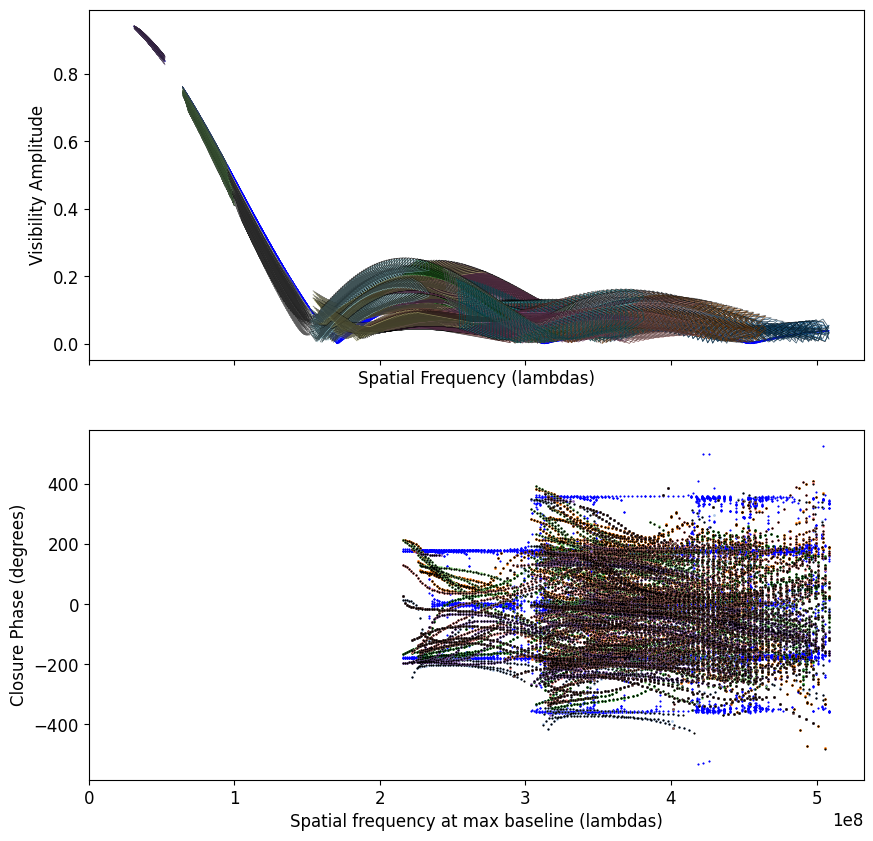

In [40]:
import jax.random as jr
times = jnp.linspace(0, 1, 8)  # Example times for the orthographic views

radius = 1.47/2.
vis_opt = visibilities(model_opt, jnp.array(u.T), jnp.array(v.T), times)
cp_opt = closure_phases(model_opt, jnp.array(u.T), jnp.array(v.T),times, cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])

vis_init = visibilities(model_init, jnp.array(u.T), jnp.array(v.T), times)
cp_init = closure_phases(model_init, jnp.array(u.T), jnp.array(v.T),times, cp_inds[0:10,0], cp_inds[0:10,1], cp_inds[0:10,2])
key = jr.PRNGKey(0)

fig1, ax_data = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

colors = plt.cm.tab20(np.linspace(0, 1, u.shape[1]))

for n in range(8):
    for i in range(u.shape[1]):
        ax_data[0].plot(jnp.sqrt(u[:,i]**2+v[:,i]**2), vis_opt[n,i,:], alpha=0.5,color=colors[i], lw=0.5, rasterized=True)
        ax_data[0].plot(jnp.sqrt(u[:,i]**2+v[:,i]**2), vis_true[n,i,:], alpha=0.5,color='k', lw=0.5, rasterized=True)
        ax_data[0].plot(jnp.sqrt(u[:,i]**2+v[:,i]**2), vis_init[n,i,:], alpha=0.5,color='blue', lw=0.5, rasterized=True, zorder=-3)

    #get the maximum baseline for each closure phase
    cp_x_axis = []
    cp_x_color = []
    for i in range(10):
        #each station in the closure phase triple
        b1 = cp_inds[i,0]
        b2 = cp_inds[i,1]
        b3 = cp_inds[i,2]
        #each baseline in the closure phase triple, and its respectice index in u, v
        matches_1 = np.all(baseline_inds == [b1,b2], axis=1)
        ind1 = np.where(matches_1)[0]
        matches_2 = np.all(baseline_inds == [b2,b3], axis=1)
        ind2 = np.where(matches_2)[0]
        matches_3 = np.all(baseline_inds == [b1,b3], axis=1)
        ind3 = np.where(matches_3)[0]
        #and the index of the closure phase triple with the maximum baseline
        #the same index is repeated n_wavs times, so just take the first one
        max_baseline_ind = jnp.argmax(
            jnp.array([jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind1],
                       jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind2],
                       jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind3]]), axis=0)[0,0]
        if max_baseline_ind == 0:
            cp_x_axis.append(jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind1])
            cp_x_color.append(ind1)
        elif max_baseline_ind == 1:
            cp_x_axis.append(jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind2])
            cp_x_color.append(ind2)
        elif max_baseline_ind == 2:
            cp_x_axis.append(jnp.sqrt((jnp.array(u.T))**2+(jnp.array(v.T))**2)[ind3])
            cp_x_color.append(ind3)
        
    cp_x_color = np.array(cp_x_color)
    #for i in range(len(cp_x_color)):
    ax_data[1].scatter(cp_x_axis, cp_opt[n,:,:], color=colors[n], rasterized=True, s=1)
    ax_data[1].scatter(cp_x_axis, cp_true[n,:,:], color='k', lw=0.5, rasterized=True, s=1)
    ax_data[1].scatter(cp_x_axis, cp_init[n,:,:], color='blue', lw=0.5, rasterized=True, s=1, zorder=-3)

ax_data[0].set_xlabel('Spatial Frequency (lambdas)')
ax_data[0].set_xlim(left=0)
ax_data[0].set_ylabel('Visibility Amplitude')
ax_data[1].set_xlabel("Spatial frequency at max baseline (lambdas)")
ax_data[1].set_xlim(left=0)
ax_data[1].set_ylabel("Closure Phase (degrees)")

In [182]:
star_interferometry.surface.y.todense()-model_opt.surface.y.todense()

Array([ 0.00000000e+00, -5.49201050e-03, -1.34009828e-02, -8.78347589e-03,
        5.99480717e-05,  9.98174023e-04, -4.75419889e-03, -5.63861813e-03,
       -2.50773757e-03, -7.14828694e-04,  8.21869677e-03,  5.06232629e-03,
       -5.41997325e-03,  9.70132942e-04,  6.70993319e-04, -6.24831734e-04,
        2.24055323e-04,  1.02305531e-03,  3.78333891e-03,  1.35803469e-02,
        3.27429813e-03,  2.90315519e-03,  2.37067240e-03,  6.63658645e-03,
       -3.44153821e-03,  1.11000443e-02, -6.28159496e-03,  1.83855540e-03,
       -7.25881461e-04, -3.15556974e-03, -1.93920393e-03, -1.22073782e-03,
        9.79287756e-03, -9.86338456e-04, -1.10185532e-03, -2.04799597e-03,
        3.24036281e-03,  5.72058428e-03,  1.93836041e-03, -1.82810422e-03,
        1.36480179e-03,  7.14019517e-03, -3.34030564e-03,  3.01889371e-03,
       -1.80498208e-03,  3.49099404e-03,  4.85072184e-06,  6.98826264e-04,
        9.22615543e-03, -5.72001798e-03, -4.29908803e-03,  4.97387865e-03,
       -1.06105690e-02,  